# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', 150)

# modeling libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from statsmodels.formula.api import logit

# utilities
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, auc
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.pipeline import Pipeline
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

Z:\Users\Don\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


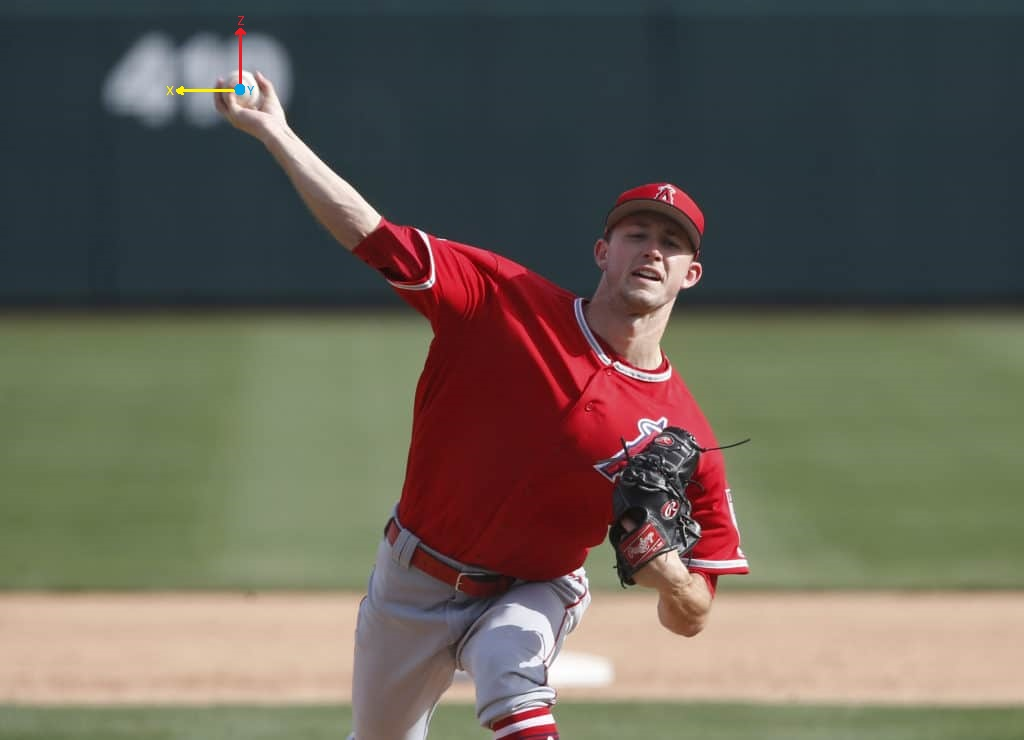

In [2]:
from IPython.display import Image
Image(filename='pitch_pic.jpg') 

To begin familiarizing with some of the features, we will first look at the coordinate system used in the dataset/pfx. The z-direction will be associated to the vertical distance, the x-direction will be associated to the horizontal distance, and the y-direction will be associated towards the catcher/batter. Note that the point of origin changes based on which feature we will be looking at like release position versus the position the ball crosses the plate. 

In [3]:
df = pd.read_csv('savant_data.csv')
print(df.shape)
df.head()

(40000, 89)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FF,2019-06-30,101.3,0.5509,6.1836,Aroldis Chapman,543877,547973,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Christian Vazquez strikes out swinging.,R,R,L,BOS,NYY,S,2.0,NaN,0,2,2019,1.1841,0.9995,-0.1572,1.5416,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183411,-4.8611,-147.1613,-10.0811,18.5249,36.4048,-15.2666,3.5,1.7,NaN,NaN,NaN,NaN,2541.0,6.6473,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.8529,NaN,NaN,0.0,1.0,0.0,0.0,NaN,92,3,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
1,CH,2019-06-30,87.2,0.5008,6.3708,Aroldis Chapman,543877,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,1,2019,-0.8553,0.1403,-0.1097,2.8397,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183325,0.2824,-126.9700,-2.5902,-9.2334,27.3368,-30.3440,3.5,1.7,NaN,NaN,NaN,NaN,2812.0,6.2259,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,54.2743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,2,Changeup,8,12,8,12,12,8,8,12,NaN,NaN
2,FF,2019-06-30,99.4,0.6354,6.2711,Aroldis Chapman,543877,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,0,2019,0.0966,1.5501,0.0167,2.6030,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183244,-1.9282,-144.5943,-8.2683,1.8397,36.6497,-8.6289,3.5,1.7,NaN,NaN,NaN,NaN,2586.0,6.4608,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,54.0394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,1,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
3,FF,2019-06-30,100.0,0.5805,6.2837,Aroldis Chapman,656308,547973,strikeout,foul_tip,NaN,NaN,NaN,NaN,5.0,Michael Chavis strikes out on a foul tip.,R,R,L,BOS,NYY,S,2.0,NaN,0,2,2019,1.0118,1.3386,0.1241,2.3864,NaN,593523.0,NaN,1,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183144,-3.7012,-145.4269,-8.6002,15.3883,35.3925,-11.1183,3.5,1.7,NaN,NaN,NaN,NaN,2596.0,6.7012,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.7990,NaN,NaN,0.0,1.0,0.0,0.0,NaN,91,3,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
4,FF,2019-06-30,98.6,0.5832,6.2344,Aroldis Chapman,656308,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,1,2019,0.2288,1.4388,-0.1114,2.2780,NaN,593523.0,NaN,1,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183100,-2.4475,-143.4481,-8.7536,3.7733,33.8462,-10.2072,3.5,1.7,NaN,NaN,NaN,NaN,2519.0,6.7412,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.7590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,2,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN


# Cleaning

There are many outcomes that can occur during a pitch so for simplicity we will group some of the less occuring events into their corresponding ones.

In [4]:
# Cleaning for events column by combining similar events to reduce noise in eda and modeling process
# Notes: Triples may need to be labeled into something else due to lack of frequency

df['events'].replace(['fielders_choice', 'fielders_choice_out', 'double_play', 'grounded_into_double_play'], 'field_out', inplace=True)
df['events'].replace('hit_by_pitch', 'walk', inplace=True)
df['events'].replace(['force_out', 'sac_fly', 'sac_bunt'], 'field_out', inplace=True)
df['events'].replace('strikeout_double_play', 'strikeout', inplace=True)
df = df[~df['events'].isin(['caught_stealing_2b', 'field_error', 'catcher_interf', 'pickoff_1b', 'caught_stealing_home', 'pickoff_caught_stealing_2b', 'pickoff_2b'])]


In [5]:
# Cleaning for description column for same reason above

df['description'].replace(['foul_tip', 'foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df['description'].replace('swinging_strike_blocked', 'swinging_strike', inplace=True)
df['description'].replace('missed_bunt', 'called_strike', inplace=True)
df['description'].replace(['foul_tip', 'foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df['description'].replace('blocked_ball', 'ball', inplace=True)
df = df[~df['description'].isin(['pitchout'])]

In [6]:
# Dropping columns that aren't related to the likelihood of throwing a strike
df = df.drop(['game_date', 'spin_dir', 'spin_rate_deprecated', 
              'break_angle_deprecated', 'break_length_deprecated', 
              'game_type', 'game_year', 'on_3b', 'on_2b', 'on_1b',
              'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2',
              'umpire', 'sv_id', 'fielder_2.1', 'fielder_3',
              'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 
              'fielder_8', 'fielder_9', 'pitch_type', 'des', 'home_team', 
              'away_team','launch_speed', 'launch_angle', 'launch_speed_angle', 'hit_distance_sc',
              'pitcher.1', 'if_fielding_alignment', 'of_fielding_alignment', 
              'woba_value', 'woba_denom', 'babip_value', 'iso_value',
              'pitcher', 'batter','hit_location','bb_type', 'hc_y', 'hc_x',
              'estimated_ba_using_speedangle','estimated_woba_using_speedangle','type',
              'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score'], axis=1)

# Reordering columns to make it easier to read
cols = df.columns.tolist()
cols = ['player_name','balls','strikes','events', 'description', 'outs_when_up', 'zone',
        'stand', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'inning',
        'inning_topbot', 'release_speed', 'release_pos_x', 'release_pos_z', 'vx0', 'vy0', 'vz0',
        'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate', 
        'release_extension', 'release_pos_y', 'at_bat_number', 'pitch_number',
        'pitch_name', 'home_score', 'away_score', 'bat_score', 'fld_score', 'game_pk']
df = df[cols]
df.head()

,player_name,balls,strikes,events,description,outs_when_up,zone,stand,p_throws,pfx_x,pfx_z,plate_x,plate_z,inning,inning_topbot,release_speed,release_pos_x,release_pos_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,game_pk
0,Aroldis Chapman,0,2,strikeout,swinging_strike,2,13.0,R,L,1.1841,0.9995,-0.1572,1.5416,9,Bot,101.3,0.5509,6.1836,-4.8611,-147.1613,-10.0811,18.5249,36.4048,-15.2666,3.5,1.7,NaN,2541.0,6.6473,53.8529,92,3,4-Seam Fastball,8,12,8,12,565068
1,Aroldis Chapman,0,1,NaN,foul,2,5.0,R,L,-0.8553,0.1403,-0.1097,2.8397,9,Bot,87.2,0.5008,6.3708,0.2824,-126.9700,-2.5902,-9.2334,27.3368,-30.3440,3.5,1.7,NaN,2812.0,6.2259,54.2743,92,2,Changeup,8,12,8,12,565068
2,Aroldis Chapman,0,0,NaN,foul,2,5.0,R,L,0.0966,1.5501,0.0167,2.6030,9,Bot,99.4,0.6354,6.2711,-1.9282,-144.5943,-8.2683,1.8397,36.6497,-8.6289,3.5,1.7,NaN,2586.0,6.4608,54.0394,92,1,4-Seam Fastball,8,12,8,12,565068
3,Aroldis Chapman,0,2,strikeout,foul,1,5.0,R,L,1.0118,1.3386,0.1241,2.3864,9,Bot,100.0,0.5805,6.2837,-3.7012,-145.4269,-8.6002,15.3883,35.3925,-11.1183,3.5,1.7,NaN,2596.0,6.7012,53.7990,91,3,4-Seam Fastball,8,12,8,12,565068
4,Aroldis Chapman,0,1,NaN,foul,1,5.0,R,L,0.2288,1.4388,-0.1114,2.2780,9,Bot,98.6,0.5832,6.2344,-2.4475,-143.4481,-8.7536,3.7733,33.8462,-10.2072,3.5,1.7,NaN,2519.0,6.7412,53.7590,91,2,4-Seam Fastball,8,12,8,12,565068


In [7]:
# We will drop row 987 because mose of the column entries are null and can't be salvaged
df = df[df['release_speed'].notnull()]

# Dropping rows with null effective speed values. Subject to change in future iterations
df = df[df['effective_speed'].notnull()]

# dropping rows where pitch type is unknown (note: consider doing the reverse of what we did for release_spin_rate)
# dropping knuckle ball, forkball, and euphus pitches due to how rare they are
df = df[df['pitch_name'].notnull()]
df = df[~df['pitch_name'].isin(['Eephus', 'Forkball', 'Knuckle Ball'])]

# imputing release_spin_rate with mean values grouped by pitch_name (i.e. curve balls spin the fastest compared to other pitches)
df['release_spin_rate'] = df['release_spin_rate'].fillna(df.groupby('pitch_name')['release_spin_rate'].transform('mean'))

# Replacing null values with 'nothing' to represent when the batter remains at bat after the result of the at bat attempt
df['events'] = df['events'].fillna('no_event')

# defining response variable that determines if the batter got on base or not (1 for strikes/outs 0 for balls or hits on base)
df['strike_result'] = df['description'].isin(['hit_into_play', 'called_strike', 'swinging_strike', 'foul']) * 1

# Converting 'zone' column into a categorical column 
df['zone'] = pd.Categorical(df['zone'])

# confirming that there are no more null values
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

# Exploratory Data Analysis

First we'll look at the statistics involved when looking at the best and worst pitcher based on our metric the strike_result. Remember we'll only be looking at starting pitchers so we have to filter out relief pitchers and closers to find the best and worst starting pitchers.

In [39]:
# We will filter out any pitchers that haven't pitched in the first inning before
starting_pitchers_names = df.player_name.loc[df['inning']==1].unique()
starting_pitchers = (df.loc[df.player_name.isin(starting_pitchers_names)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'at_bat_number':'count',
                              'pitch_name':lambda x:x.value_counts().index[0],
                              'release_pos_x':'mean',
                              'release_pos_y':'mean',
                              'release_pos_z':'mean',
                              'release_extension':'mean',
                              'pfx_x':'mean',
                              'pfx_z':'mean'})
                        .sort_values(by='strike_result', ascending=False))
best_pitchers = starting_pitchers.head(20)
worst_pitchers = starting_pitchers.tail(20)
pd.concat([best_pitchers, worst_pitchers], axis='rows')



,release_speed,strike_result,at_bat_number,pitch_name,release_pos_x,release_pos_y,release_pos_z,release_extension,pfx_x,pfx_z
player_name,,,,,,,,,,
Max Scherzer,89.140670,0.708134,209,4-Seam Fastball,-3.444684,54.670836,5.340946,5.828665,-0.463185,0.600982
Bryse Wilson,92.304938,0.691358,81,4-Seam Fastball,-3.299284,54.321744,5.513777,6.177728,-0.547493,0.921809
Noe Ramirez,82.668831,0.688312,77,Curveball,-2.411816,55.078836,4.922806,5.420675,-0.060570,0.070838
Patrick Corbin,87.595000,0.670000,100,2-Seam Fastball,2.454508,54.300999,6.425273,6.198540,0.652549,0.677704
David Price,88.556250,0.666667,96,Changeup,3.481049,54.719951,5.745940,5.779500,1.112675,0.816492
Matt Strahm,86.793827,0.666667,81,4-Seam Fastball,2.367935,54.779242,5.177252,5.720272,0.378959,0.601133
Brendan McKay,89.965432,0.666667,81,4-Seam Fastball,1.014185,54.317415,6.029983,6.182099,0.195916,0.884220
Aaron Nola,85.303977,0.664773,176,Knuckle Curve,-1.798791,54.061258,4.890887,6.438244,-0.273872,0.055513
Chris Paddack,89.791160,0.657459,181,4-Seam Fastball,-2.495464,53.703017,6.275098,6.796514,-0.575067,1.121038


As seen above, Max Scherzer is our 'best' pitcher, and Mike Clevinger our 'worst'.

In [9]:
# filtering out non-starters and sorting events into chronological order
game_stats = (df.loc[df.player_name.isin(starting_pitchers_names)]
                   .sort_values(['game_pk','inning', 'inning_topbot', 'outs_when_up', 'at_bat_number', 'pitch_number'],
                         ascending=[False, True, False, True, True, True]))

# aggregating performance of each pitcher into games played into number of innings played and how many points given
season_stats = (game_stats.groupby(['game_pk', 'player_name'])
                          .agg({'bat_score':lambda x: x.max() - x.min(),
                                'inning': lambda x: x.max() - x.min() + 1}))

# creating a feature called ERA (Earned Run Average) representing the number of runs given for the season so far.
season_stats['ERA'] = round(season_stats['bat_score']*9 / season_stats['inning'], 2)
season_stats = season_stats.groupby('player_name').agg({'ERA':'mean', 'inning':'sum'}).sort_values('ERA').head()


low_era_pitchers = (df.loc[df.player_name.isin(season_stats.index)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'at_bat_number':'count',
                              'pitch_name':lambda x:x.value_counts().index[0],
                              'release_pos_x':'mean',
                              'release_pos_y':'mean',
                              'release_pos_z':'mean',
                              'release_extension':'mean',
                              'pfx_x':'mean',
                              'pfx_z':'mean'})
                        .sort_values(by='strike_result', ascending=False))

low_era_pitchers


,release_speed,strike_result,at_bat_number,pitch_name,release_pos_x,release_pos_y,release_pos_z,release_extension,pfx_x,pfx_z
player_name,,,,,,,,,,
Daniel Mengden,86.002151,0.645161,93,4-Seam Fastball,-1.611784,54.275319,5.885624,6.224161,-0.150159,0.733908
John Means,87.236145,0.614458,83,4-Seam Fastball,0.680183,54.638670,6.519657,5.860867,0.578743,1.417798
Chad Green,94.703571,0.607143,28,4-Seam Fastball,-2.101182,54.310464,5.913082,6.189000,-0.452057,1.132879
Matt Carasiti,94.151111,0.555556,45,Sinker,-2.064160,54.666064,6.035233,5.833333,-0.977502,0.820591
Aaron Civale,86.677907,0.511628,86,Sinker,-1.305345,55.185731,6.018490,5.313802,-0.232423,0.449184


We will now compare 3 pitchers with very different skill levels. Max Scherzer who has the best strike rate, Marcus Stroman who is the highest paid pitcher on the Blue Jays, and Mike Clevinger who is worst performing pitcher this year. By grouping the different pitches that these pitchers can use, we can discover subtle differences between them.

In [10]:
player_comparison = (df[df.player_name.isin(['Max Scherzer', 'Mike Clevinger', 'Marcus Stroman'])]
 .groupby(['pitch_name','player_name'])
 .agg({'release_speed':'mean',          
      'at_bat_number':'count',
      'pitch_name':lambda x:x.value_counts().index[0],
       'vx0':'mean',
       'vy0':'mean',
       'vz0':'mean',
       'ax':'mean',
       'ay':'mean',
      'release_pos_x':'mean',
      'release_pos_y':'mean',
      'release_pos_z':'mean',
      'release_extension':'mean',
      'release_spin_rate':'mean',
      'pfx_x':'mean',
      'pfx_z':'mean',
      'strike_result':'mean'})
)
player_comparison

release_speed  at_bat_number       pitch_name  \
pitch_name      player_name                                                     
2-Seam Fastball Marcus Stroman      92.662500             40  2-Seam Fastball   
4-Seam Fastball Marcus Stroman      93.085714              7  4-Seam Fastball   
                Max Scherzer        95.295455             88  4-Seam Fastball   
                Mike Clevinger      96.303704             27  4-Seam Fastball   
Changeup        Marcus Stroman      87.600000              3         Changeup   
                Max Scherzer        83.939394             33         Changeup   
                Mike Clevinger      90.000000              8         Changeup   
Curveball       Marcus Stroman      73.600000              2        Curveball   
                Max Scherzer        78.418750             16        Curveball   
                Mike Clevinger      77.788889              9        Curveball   
Cutter          Marcus Stroman      91.356000             50           Cutter   
                Max Scherzer        89.911765             17           Cutter   
Slider          Marcus Stroman      86.560294             68           Slider   
                Max Scherzer        85.294545             55           Slider   
                Mike Clevinger      80.562500              8           Slider   

                                      vx0         vy0       vz0         ax  \
pitch_name      player_name                                                  
2-Seam Fastball Marcus Stroman   4.983645 -134.841375 -3.036985 -12.799878   
4-Seam Fastball Marcus Stroman   4.994429 -135.464014 -2.810429  -4.630743   
                Max Scherzer    11.162019 -138.214139 -4.728298 -14.924670   
                Mike Clevinger   4.045226 -140.220889 -5.986300  -6.778993   
Changeup        Marcus Stroman   6.422133 -127.414767 -4.200467 -11.496633   
                Max Scherzer     9.068003 -121.845679 -2.803448 -14.309473   
                Mike Clevinger   5.507850 -131.048587 -5.709325 -13.030487   
Curveball       Marcus Stroman   2.444750 -106.927200 -1.494700   8.536800   
                Max Scherzer     4.471944 -114.077500  0.748044   7.170719   
                Mike Clevinger  -0.632089 -113.185689  1.228133   8.352656   
Cutter          Marcus Stroman   5.143366 -132.916132 -1.918036  -0.327896   
                Max Scherzer    10.041453 -130.517847 -4.484559  -1.294006   
Slider          Marcus Stroman   3.444304 -125.945756 -1.957790   7.148404   
                Max Scherzer     8.651307 -123.850404 -1.478180   1.413389   
                Mike Clevinger  -0.439412 -117.269825 -0.441037  14.707512   

                                       ay  release_pos_x  release_pos_y  \
pitch_name      player_name                                               
2-Seam Fastball Marcus Stroman  25.760488      -1.400732      54.804125   
4-Seam Fastball Marcus Stroman  26.453929      -1.206557      54.679386   
                Max Scherzer    29.418499      -3.393165      54.615100   
                Mike Clevinger  30.679911      -1.624515      53.804385   
Changeup        Marcus Stroman  23.084800      -1.394967      54.758800   
                Max Scherzer    22.829933      -3.469291      54.626206   
                Mike Clevinger  24.670412      -1.454425      53.595487   
Curveball       Marcus Stroman  17.656050      -1.531800      56.159600   
                Max Scherzer    19.181556      -3.344212      54.949612   
                Mike Clevinger  19.815867      -1.253789      54.758756   
Cutter          Marcus Stroman  25.126082      -1.411634      54.932766   
                Max Scherzer    24.485988      -3.466041      54.716247   
Slider          Marcus Stroman  23.120596      -1.446850      55.100301   
                Max Scherzer    24.174227      -3.534978      54.691658   
                Mike Clevinger  21.951837      -1.565788      54.574463   

                                release_pos_z  rele

Speed doesn't seem to be the most important factor that determines a strike as generally assumed. Mike Clevinger's 4-seam fastball release speed seems to be the fastest, but simultaneously the worst performaning amongst the two other pitchers. One important difference observed is the vx0, and ax0 features are significantly greater for Max Scherzer compared to the other two pitchers. It is possible that a high vx0, and ax0 attribute to a higher strike chance. 

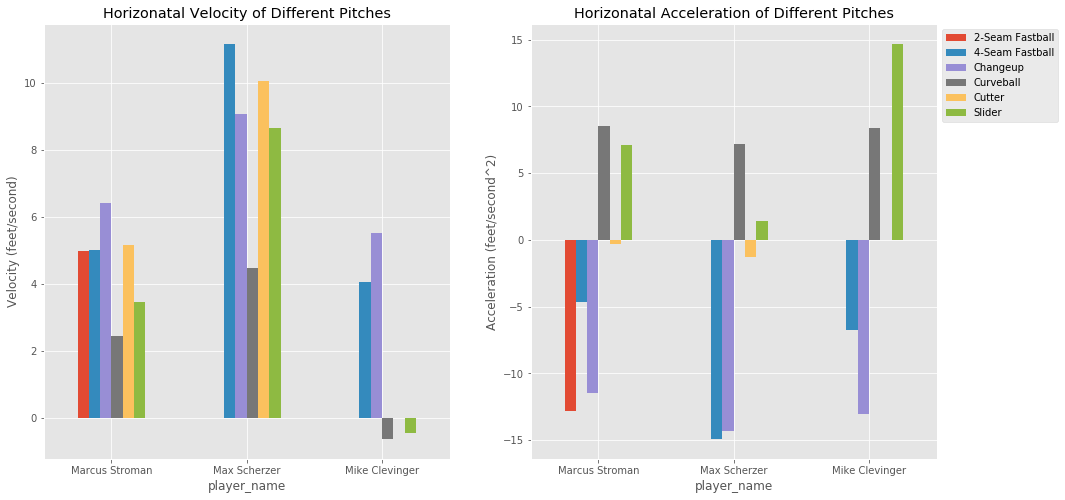

In [11]:
fig3, (ax3, ax4) = plt.subplots(1,2, figsize=(16,8))

_ = player_comparison['vx0'].unstack(level=0).plot(kind='bar', rot=0, ax=ax3, legend=False)
_ = ax3.set_title('Horizonatal Velocity of Different Pitches')
_ = ax3.set_ylabel('Velocity (feet/second)')

_ = player_comparison['ax'].unstack(level=0).plot(kind='bar', rot=0, ax=ax4)
_ = ax4.set_title('Horizonatal Acceleration of Different Pitches')
_ = ax4.set_ylabel('Acceleration (feet/second^2)')
_ = plt.legend(bbox_to_anchor=(1,1), loc='upper left')

One intersting oberservation above is that Max's 4-seam fastball and changeup are the most identical in terms of vx0 and particularly ax0. Given that Max's success rate for the changeup is the highest at a 75.7% mark, this may be a large contributing factor. What this would mean is that Max is successfully tricking batters into thinking he's about to throw a 4-seam fastball when he's throwing a changeup or vice versa, based on the way he swings out his arm.

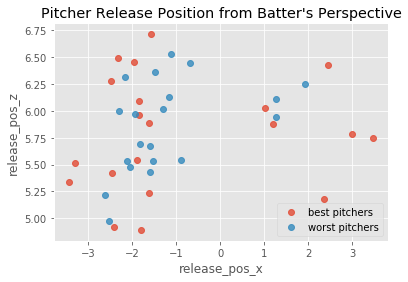

In [40]:

#_ = sns.regplot('release_pos_x', 'release_pos_z', data=low_era_pitchers, fit_reg=False, label='low era pitchers')
_ = sns.regplot('release_pos_x', 'release_pos_z', data=best_pitchers, fit_reg=False, label='best pitchers')
_ = sns.regplot('release_pos_x', 'release_pos_z', data=worst_pitchers, fit_reg=False, label='worst pitchers')
_ = plt.title('Pitcher Release Position from Batter\'s Perspective')
_ = plt.legend(loc='lower right')

For ease of understanding, imagine the pitcher standing where x-axis equals zero, and the point of release is where the dot lies on the plot. The difference in the horizonatal release points between the good and bad pitchers is a really interesting pattern. From this observation we can hypothesize that pitchers who release the ball further from their bodies have higher success rate of striking out batters. Height and arm length may be a big contributing factor in release_pos_x as well.

Note: negative values of release_pos_x represent right handed pitchers and postive x values correspond to left handers

Z:\Users\Don\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


''

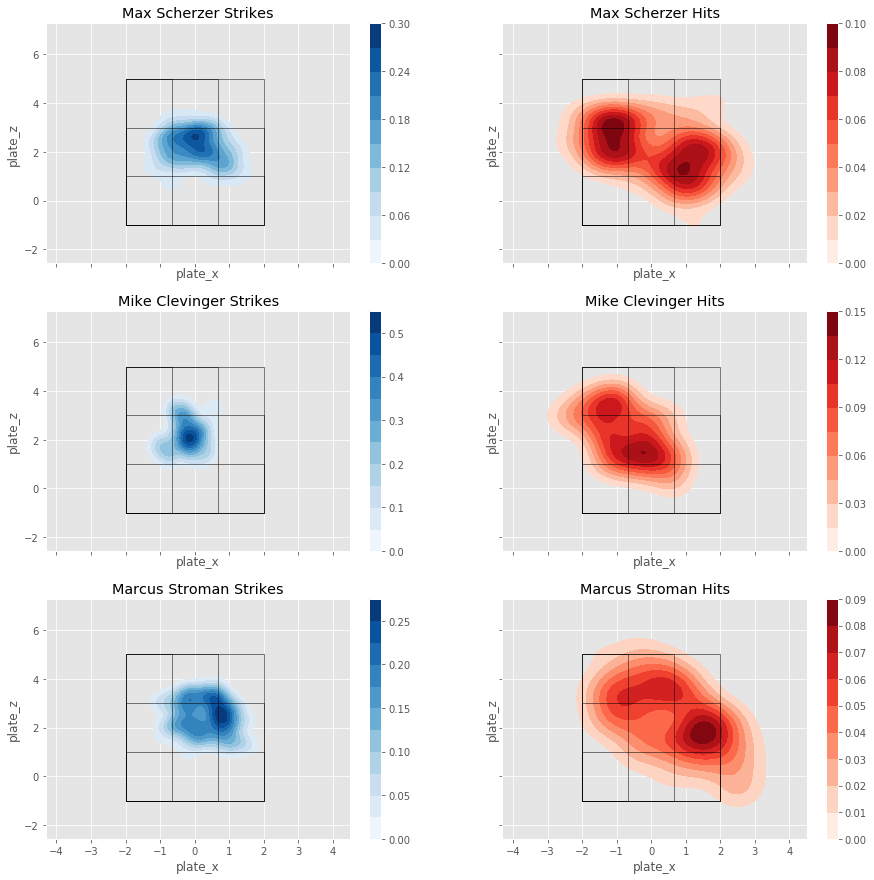

In [13]:
scherzer_strikes = df[(df['player_name']=='Max Scherzer')  & (df.strike_result==1)]
clevinger_strikes = df[(df['player_name']=='Mike Clevinger')  & (df.strike_result==1)]
stroman_strikes = df[(df['player_name']=='Marcus Stroman')  & (df.strike_result==1)]
scherzer_hits = df[(df['player_name']=='Max Scherzer') & (df.strike_result==0)]
clevinger_hits = df[(df['player_name']=='Mike Clevinger') & (df.strike_result==0)]
stroman_hits = df[(df['player_name']=='Marcus Stroman') & (df.strike_result==0) ]


fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(15,15))

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 4, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 2, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (4/3), 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (8/3), 6, fill=False, edgecolor='black'))

sns.kdeplot(scherzer_strikes['plate_x'] , scherzer_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[0,0], cbar=True).set_title('Max Scherzer Strikes')
sns.kdeplot(clevinger_strikes['plate_x'] , clevinger_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[1,0], cbar=True).set_title('Mike Clevinger Strikes')
sns.kdeplot(stroman_strikes['plate_x'] , stroman_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[2,0], cbar=True).set_title('Marcus Stroman Strikes')

sns.kdeplot(scherzer_hits['plate_x'] , scherzer_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[0,1], cbar=True).set_title('Max Scherzer Hits')
sns.kdeplot(clevinger_hits['plate_x'] , clevinger_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[1,1], cbar=True).set_title('Mike Clevinger Hits')
sns.kdeplot(stroman_hits['plate_x'] , stroman_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[2,1], cbar=True).set_title('Marcus Stroman Hits')
;

Max and Marcus seems to have a larger distribution that spreads across zones 4,5,6 whereas the worst pitcher(Mike) has a smaller distribution concentrated around zone 5. This may be a major contributing factor towards a pitcher's success.

There are a few interesting hypothesis that can be drawn from the two graphs seen above:          
    1) higher release_pos_x (aka greater height/longer arms) is directly related to the likelihood of throwing a strike     
    2) A more varied toolbox of different pitches can result in more strikes     
    3) The more similar the fastball and changeup pitches look (in terms of vx0, ax0), the more successful they can be at striking batters out          
    4) The more zones the pitcher can pitch to can lead to a higher chance to striking the batter out

# Feature Selection

In [14]:
def calculate_vif_(X, thresh=5.0):
    """
    Function to calculate and eliminates any independent features that are correlated with each other and
    will print those features out. The function will return the remaining dataframe free of multicollinearity.
    
    X (dataframe): dataframe of independent variables
    thresh (float): threshold value to determine how correlated features can be before removing them
    """
    
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [15]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    """
    Function that identifies features that are too highly correlated with the dependent variable and
    returns a list of features to keep.
    
    df1 (Dataframe): The independent variable(s).
    target (Series): the dependent variable
    """
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [16]:
str_cols = df.columns[(df.dtypes=='object') | (df.dtypes=='category')]
df_num = df[df.columns[~df.columns.isin(list(str_cols))]]
df_str = pd.get_dummies(df[str_cols].drop(['player_name', 'events', 'description'],axis='columns'))
df_all = pd.concat([df_num, df_str], axis='columns')
X = df_all.drop('strike_result', axis='columns')
y = df_all['strike_result']


In [17]:
# Identifying features that are too correlated to the dependant variable using the IV method and picking 
# features that have an IV more than 0.001
final_iv, IV = data_vars(X, y)
var_name  = IV.sort_values('IV', ascending=False)
X = X[list(var_name.VAR_NAME[var_name['IV'] > 0.001])]
X.columns


Index(['zone_14.0', 'zone_11.0', 'zone_5.0', 'zone_13.0', 'zone_4.0',
       'zone_6.0', 'zone_2.0', 'zone_12.0', 'zone_8.0', 'zone_9.0', 'zone_7.0',
       'zone_1.0', 'zone_3.0', 'plate_z', 'balls', 'pitch_number', 'pfx_z',
       'effective_speed', 'pitch_name_4-Seam Fastball', 'vy0', 'plate_x', 'ay',
       'release_speed', 'az', 'pitch_name_Curveball'],
      dtype='object')

In [18]:
# eliminating features that are collinear with each other
X = calculate_vif_(X, thresh=5.0)

dropping 'vy0' at index: 19
dropping 'zone_14.0' at index: 0
dropping 'release_speed' at index: 20
dropping 'effective_speed' at index: 16
dropping 'ay' at index: 18
dropping 'plate_z' at index: 12
dropping 'pitch_number' at index: 13
dropping 'az' at index: 16
Remaining variables:
Index(['zone_11.0', 'zone_5.0', 'zone_13.0', 'zone_4.0', 'zone_6.0',
       'zone_2.0', 'zone_12.0', 'zone_8.0', 'zone_9.0', 'zone_7.0', 'zone_1.0',
       'zone_3.0', 'balls', 'pfx_z', 'pitch_name_4-Seam Fastball', 'plate_x',
       'pitch_name_Curveball'],
      dtype='object')


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeling

We will be building a logistic regression model using the stats model due to its ease of readability with statistical testing. The other advantage of logistic regression is its ease of interpretablility of the assigned weighting to it's features.

In [20]:
m = sm.Logit(y_train, X_train).fit()
m.summary()

Optimization terminated successfully.
         Current function value: 0.525759
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          strike_result   No. Observations:                27293
Model:                          Logit   Df Residuals:                    27276
Method:                           MLE   Df Model:                           16
Date:                Thu, 14 Nov 2019   Pseudo R-squ.:                  0.2281
Time:                        22:29:33   Log-Likelihood:                -14350.
converged:                       True   LL-Null:                       -18589.
                                        LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
zone_11.0                     -1.2374      0.059    -20.896      0.000      -1.353      -1.121
zone_5.0                       1.9964      0.071     28.302      0.000       1.858       2.135
zone_13.0                     -0.9262      0.049    -18.776      0.000      -1.023      -0.830
zone_4.0                       1.8239      0.083     22.082      0.000       1.662       1.986
zone_6.0                       2.2291      0.077     28.908      0.000       2.078       2.380
zone_2.0                       2.1773      0.093     23.491      0.000       1.996       2.359
zone_12.0                     -0.1735      0.053     -3.293      0.001      -0.277      -0.070
zone_8.0                       1.7825      0.070     25.323      0.000       1.644       1.920
zone_9.0                       1.9280      0.071     27.230      0.000       1.789       2.067
zone_7.0                       1.5495      0.081     19.076      0.000       1.390       1.709
zone_1.0                       1.6122      0.090     17.839      0.000       1.435       1.789
zone_3.0                       2.0740      0.093     22.334      0.000       1.892       2.256
balls                          0.0766      0.015      5.194      0.000       0.048       0.106
pfx_z                         -0.1769      0.032     -5.477      0.000      -0.240      -0.114
pitch_name_4-Seam Fastball    -0.0559      0.043     -1.307      0.191      -0.140       0.028
plate_x                       -0.4434      0.024    -18.171      0.000      -0.491      -0.396
pitch_name_Curveball          -0.4742      0.064     -7.368      0.000      -0.600      -0.348
==============================================================================================
"""

In [21]:
# Removing columns that aren't statistically significant
drop_cols = X.columns[m.pvalues >= 0.05]
X = X.drop(drop_cols, axis='columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Retrain model
m = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.526218
         Iterations 6


In [22]:
# Finding the best threshold value to decide between a strike and a hit by testing 10 values
prob = np.arange(1,10,.02)/10
max_val = 0

for i in prob:
    y_pred = m.predict(X_train).apply(lambda x: 1 if x>i else 0)
    train_score = roc_auc_score(y_train, y_pred)
    if train_score > max_val:
        max_val = train_score
        max_i = i
print('best threshold value =',max_i)
print('corresponding training auc score = ', max_val)

best threshold value = 0.7560000000000006
corresponding training auc score =  0.7729147633892859


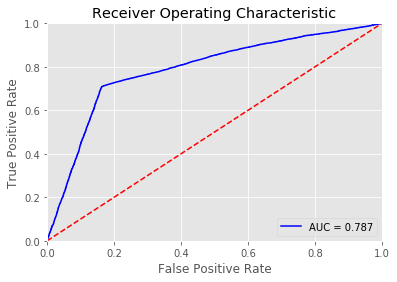

optimal threshold value = 0.7557082790872585


In [23]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = m.predict(X_train)
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print('optimal threshold value =', optimal_threshold)

# Performance

In [24]:
y_test_pred = m.predict(X_test).apply(lambda x: 1 if x>optimal_threshold else 0)
print('testing auc score = ', roc_auc_score(y_test, y_test_pred))

testing auc score =  0.7707598938491513


# Conclusion

With the final modeling finished, we can now use the logistic regression weighting results to determine the most important features, and make informative decisions how which pitcher is overvalued, and likewise, which ones are undervalued.

In [25]:
np.exp(m.params.sort_values(ascending=False)).index

Index(['zone_6.0', 'zone_2.0', 'zone_3.0', 'zone_5.0', 'zone_9.0', 'zone_4.0',
       'zone_8.0', 'zone_1.0', 'zone_7.0', 'balls', 'zone_12.0', 'pfx_z',
       'plate_x', 'pitch_name_Curveball', 'zone_13.0', 'zone_11.0'],
      dtype='object')

In [26]:
# feature importance for stats logisitic regression
pd.DataFrame(np.exp(m.params.sort_values(ascending=False)), columns=['feature importance'])


,feature importance
zone_6.0,9.422992
zone_2.0,8.872649
zone_3.0,7.984899
zone_5.0,7.404507
zone_9.0,6.822729
zone_4.0,6.046533
zone_8.0,6.020497
zone_1.0,4.984599
zone_7.0,4.743863
balls,1.071807


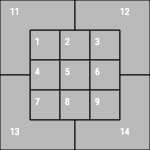

In [27]:
Image(filename= 'zones.png')

Notice how the most influential features end up being ones that are related to zone areas. This would indicate that certain areas have a higher probability of being a strike and that a pitcher's accuracy is also important (refer to the diagram above to identify locations of each zone). Although this is an interesting result, it is not a practical strategy to only throw to zone 6 as the batter will eventually catch on. We will only be looking at pfx_z since it is the most influential and practical feature to pick out good pitchers. Using this this knowledge of what features make a successful pitcher, we can identify undiscovered talented pitchers. In addition to finding the most talented pitchers, we have to keep in mind the cost so we will need data on their current salaries. In this case, we will only be looking at pitchers who are paid under 1 million.

In [28]:
df3 = (df[df.player_name.isin(starting_pitchers_names)].groupby('player_name')
         .agg({'pfx_z':'mean',
               'plate_x':'mean',
               'ay':'mean',
               'az':'mean', 
               'vy0':'mean',
               'release_speed':'mean',
               'strike_result':'mean', 
               'inning':'count'})
         .sort_values(by=['pfx_z'], ascending=False)
         .reset_index()
          )

df_salaries = pd.read_excel('salary.xlsx')
sp_salaries = df_salaries[['Name', 'Team', 'Avg Annual']][df_salaries['POS']=='SP']
df_all = pd.merge(df3, sp_salaries, left_on='player_name', right_on='Name', how='right').dropna()
df_all['Avg Annual'] = df_all['Avg Annual'].astype(int)
#df_all = df_all[df_all['Avg Annual']<=1000000]

''

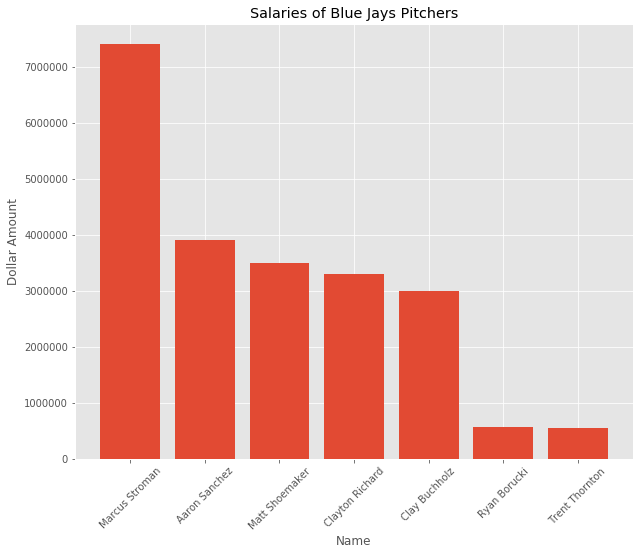

In [29]:
bj_pitcher_salary = df_salaries[(df_salaries.Team=='TOR ') & (df_salaries.POS=='SP')]
plt.figure(figsize=[10,8])
plt.title('Salaries of Blue Jays Pitchers')
plt.xlabel('Name')
plt.ylabel('Dollar Amount')
plt.bar(bj_pitcher_salary.Name, bj_pitcher_salary['Avg Annual'])
plt.xticks(rotation=45)
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor");
;

In [30]:
(df[df.player_name.isin(list(bj_pitcher_salary.Name))]
     .groupby('player_name')
     .agg({'pfx_z':'mean', 'strike_result':'mean', 'inning':'count'})
     .sort_values(by=['pfx_z'], ascending=False))

,pfx_z,strike_result,inning
player_name,,,
Trent Thornton,0.623450,0.517442,172
Aaron Sanchez,0.483208,0.508571,175
Marcus Stroman,0.348979,0.576471,170
Clayton Richard,0.245683,0.545455,77


In [31]:
bj_pitcher_salary.Name

184     Marcus Stroman
291      Aaron Sanchez
303     Matt Shoemaker
312    Clayton Richard
331      Clay Buchholz
673       Ryan Borucki
861     Trent Thornton
Name: Name, dtype: object

In [32]:
(df[df.player_name.isin(list(bj_pitcher_salary.Name))].groupby('player_name')
     .agg({'pfx_z':'mean', 'strike_result':'mean', 'inning':'count'})
     .sort_values(by=['pfx_z'], ascending=False))

,pfx_z,strike_result,inning
player_name,,,
Trent Thornton,0.623450,0.517442,172
Aaron Sanchez,0.483208,0.508571,175
Marcus Stroman,0.348979,0.576471,170
Clayton Richard,0.245683,0.545455,77


In [33]:
(df_all[df_all.Name.isin(list(bj_pitcher_salary.Name))]
     .groupby('player_name')
     .agg({'pfx_z':'mean', 'strike_result':'mean', 'inning':'count'})
     .sort_values(by=['pfx_z'], ascending=False))

,pfx_z,strike_result,inning
player_name,,,
Trent Thornton,0.623450,0.517442,1
Aaron Sanchez,0.483208,0.508571,1
Marcus Stroman,0.348979,0.576471,1
Clayton Richard,0.245683,0.545455,1


In [34]:
# Highest pfx_z
df_all.sort_values(by=['pfx_z'], ascending= False).set_index('player_name').head(5)

,pfx_z,plate_x,ay,az,vy0,release_speed,strike_result,inning,Name,Team,Avg Annual
player_name,,,,,,,,,,,
Chris Paddack,1.121038,-0.034676,26.565494,-16.975289,-130.555692,89.791160,0.657459,181.0,Chris Paddack,SD,555000
Blake Snell,1.120256,0.070185,28.395799,-16.318547,-134.003529,92.150625,0.612500,160.0,Blake Snell,TB,10000000
Lucas Giolito,1.112967,0.292511,25.916894,-17.416477,-130.295408,89.553049,0.585366,164.0,Lucas Giolito,CWS,573000
Andrew Cashner,1.074511,-0.294734,24.915442,-19.005848,-128.350931,88.335204,0.576531,196.0,Andrew Cashner,BAL,8000000
J.A. Happ,1.067922,0.438034,25.685451,-18.801338,-131.776421,90.627941,0.470588,68.0,J.A. Happ,NYY,17000000


In the table above, we can see a list of pitchers who are much more cost efficient and effective as pitchers compared to some of the players on the Blue Jays roster. Chris Paddack, Lucas Giolito, Eduardo Rodrguez, and  	Trevor Richards are all starting pitchers who fit the description and are a fraction of what Marcus Stroman is being paid. If the Blue Jays can find an opportunity to obtain these players, they will definitely be able to see an improvement with the number of strikes they can get in a game, resulting in more wins. 